### Airbnb Classification

**Airbnb Business Model**

**Marketplace** that connect people who offers home with peope who wants to rent a home. 

Offert:
* Portfolio Density/Diversity
* Portfolio Size
* Average Price

Demand:
* LTV
* CAC
* Number of Users



**Business Problem**

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

**Data Description**

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 




**Solution**
1. Predict and load in a database, use data visualization to see results

2. API: 
    * Input: id and customer features
    * Output: id + predict + probability

# 0.0. Load


## 0.1. Imports


In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics 

from keras import models as ml
from keras import layers as l

from scikitplot import metrics as mt

import random


2022-04-27 05:15:45.174301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 05:15:45.174403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0.2. Helper Functions

## 0.3. Load Dataset

In [16]:
df_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('../data/sessions.csv')

# 1.0. Data Description

In [84]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [85]:
print('Train dataset:')
print('Rows:{}'.format(df_raw.shape[0]))
print('Cols:{}'.format(df_raw.shape[1]))

print('\nSessions dataset:')
print('Rows:{}'.format(df_sessions.shape[0]))
print('Cols:{}'.format(df_sessions.shape[1]))

Train dataset:
Rows:213451
Cols:16

Sessions dataset:
Rows:9213930
Cols:6


## 1.2. Data Types

In [86]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [87]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [88]:
df1.sample().T

,58302
id,twnwo5rxre
date_account_created,2013-01-30
timestamp_first_active,20130130211806
date_first_booking,NaN
gender,-unknown-
age,NaN
signup_method,basic
signup_flow,0
language,en
affiliate_channel,direct


In [89]:
df_sessions.sample().T

,2647016
user_id,f71vd7p3kh
action,update
action_type,submit
action_detail,update_listing
device_type,Windows Desktop
secs_elapsed,39050.0


## 1.2. NA Check

In [90]:
df1.isna().sum()/len(df1)


id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [91]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.3 Fill NA

In [94]:
#==================Training================
#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking']=df1['date_first_booking'].fillna(date_first_booking_max)

#age
age_mean = df1['age'].mean()
df1['age'] = df1['age'].fillna(age_mean)

# first_affiliate_tracked

df1 = df1[-df1.isna()]

#==================Sessions==============


## 1.4. Change Data Type

In [114]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format = '%Y-%m-%d')

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'], format = '%Y-%m-%d')
#age
df1['age'] = df1['age'].astype('int64')



In [98]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.5. Check Balanced Data

In [99]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

# 2.0. Data Filtering

In [100]:
df2= df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selections

# 3.0. Feature Engineering

In [117]:
df1.sample().T
#account life time - max date - date account created 
df1['account_lifetime']= (pd.to_datetime(date_first_booking_max) - df1['date_account_created']).dt.days

In [120]:
df1.sample().T

,116764
id,kxyf47pwc6
date_account_created,2013-10-14 00:00:00
timestamp_first_active,2013-10-14 19:31:47
date_first_booking,2013-10-16 00:00:00
gender,FEMALE
age,38
signup_method,basic
signup_flow,0
language,en
affiliate_channel,direct


In [109]:
timedelta?

Object `timedelta` not found.


# 3.0. Data Preparation

In [11]:
df3 = df2.copy()

In [12]:
#dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id','country_destination'], axis=1))

#join id and country destination
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis=1)

# 4.0. Feature Selections

In [121]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] #original dates
df4 = df3.drop(cols_drop, axis=1)

In [122]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

# 5.0. Machine Learning Model

In [123]:
weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

## 5.1. Baseline Model

In [158]:
import random

country_destination_list = df4['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
weights  = y_test.value_counts(normalize=True).sort_index().tolist()
yhat_random = random.choices(population=country_destination_list, k=k_num, weights=weights)

## 5.2. Neural Network - MLP

In [125]:
#split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [133]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)



In [127]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [128]:
#model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1] , activation='relu'))
model.add(l.Dense(11, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
model.fit(x_train, y_train_nn, epochs=100)

2022-04-27 06:31:40.562260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 06:31:40.562338: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 06:31:40.562402: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (heitor-Lenovo-ideapad-330-15IKB): /proc/driver/nvidia/version does not exist
2022-04-27 06:31:40.595533: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1225/1705 [====================>.........] - ETA: 0s - loss: 1.3053 - accuracy: 0.7082

KeyboardInterrupt: 

# 6.0. Performance

## 6.1. Baseline Performance

Accuracy score: 0.514998166483315
Balanced accuracy score: 0.08883532220107673
Kappa score: -0.0009196383845024858


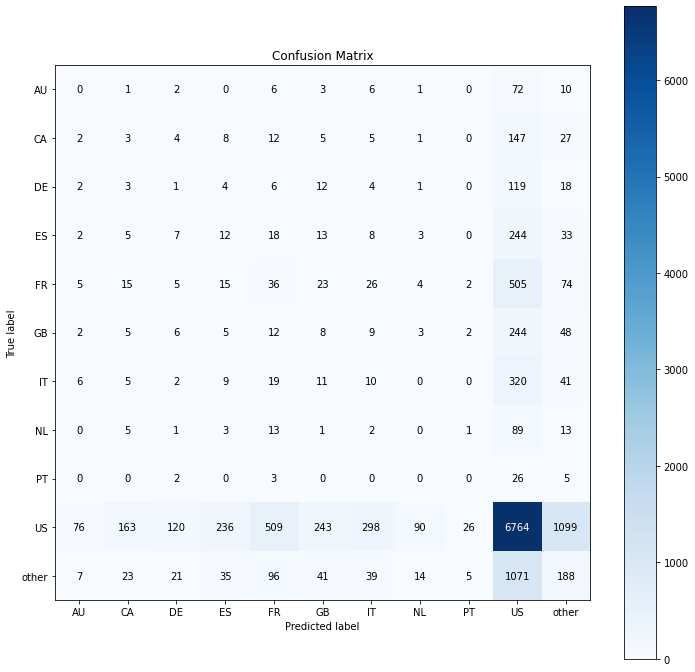

In [159]:
#Accuracy
acc_random = metrics.accuracy_score(y_test, yhat_random)
print(f'Accuracy score: {acc_random}')


#Balanced accurace
balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced accuracy score: {balanced_acc_random}')

#Kappa
kappa_random = metrics.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa score: {kappa_random}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 6.2. NN Performance

In [160]:
#prediction
pred_nn = model.predict(x_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

In [1]:
yhat_nn.value_counts()

NameError: name 'yhat_nn' is not defined

Accuracy score: 0.7030436376971031
Balanced accuracy score: 0.09126170915008681
Kappa score: 0.0025565848047993667


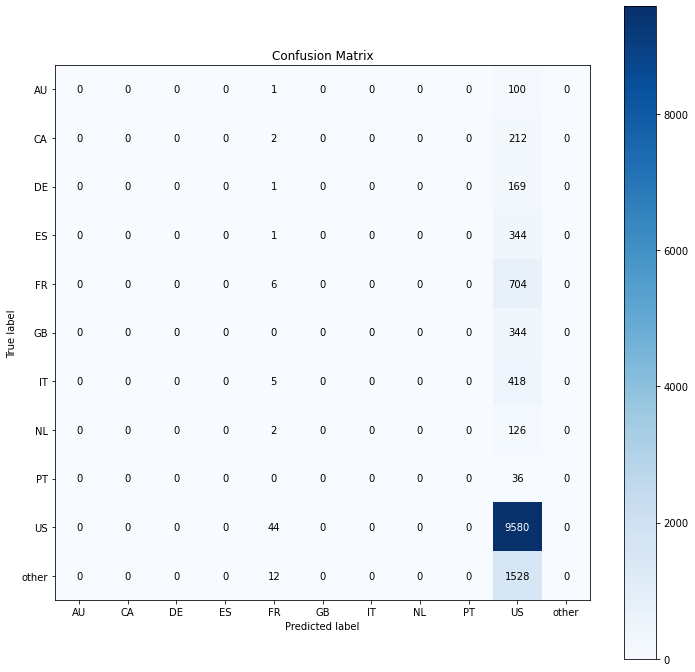

In [162]:
#Accuracy
acc_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy score: {acc_nn}')


#Balanced accurace
balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced accuracy score: {balanced_acc_nn}')

#Kappa
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));



In [163]:
print(metrics.classification_report(y_test_nn, yhat_nn))

/home/heitor/repos/airbnb_booking_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.08      0.01      0.02       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.00      0.00      0.00      1540

    accuracy                           0.70     13635
   macro avg       0.07      0.09      0.08     13635
weighted avg       0.50      0.70      0.58     13635



/home/heitor/repos/airbnb_booking_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/heitor/repos/airbnb_booking_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
def get_model_metrics(model_trained, X_test, y_test):
    
    yhat = model.predict(X_test)
    
    #balanced accuracy
    balanced_acc= metrics.balanced_accuracy_score(y_test, yhat)
 
    kappa_acc = metrics.cohen_kappa_score(y_test, yhat_)
    
    return balanced_acc, kappa_acc


#stratified kfold
num_folds=5

def cv(model, kfold, X_train, X_test, y_train, y_test):
    kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    balanced_acc_list = []
    kappa_list = []

    i= 1
    for train_ix, val_ix in kfold.split(x_train, y_train):
        print('Fold number {}'.format(i))
        #get fold
        x_train_fold = x_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        x_val_fold = x_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        model.fit(x_train_fold, y_train_fold)
        print(f'{i}/{kfold}')
        
        i+=1
        
    print(f'Balanced Accuracy CV = {np.mean(balanced_acc_list)}')
    print(f'Kappa Score CV = {np.mean(kappa_list)}')

In [166]:
cv(K)

Balanced Accuracy CV = 0.09116993424226723
Kappa Score CV = 0.0026375158080812256


SyntaxError: invalid syntax (1463043433.py, line 1)